<a href="https://colab.research.google.com/github/MrKarn/DAA/blob/main/emotion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction
<hr>

Humans communicate using facial expressions as well as other body language and verbal cues. Researchers are using deep learning approaches in artificial intelligence research as a way to help make decisions. They need to study people in order to predict how they'll respond or know what they're feeling. This study proposes the development of a system that predicts and classifies facial emotions by using the Convolution Neural Network algorithm, among other features.

Data preprocessing, facial feature extraction, and facial emotion classification are the three key steps in this notebook. Facial expressions were predicted with 62.66% accuracy using the Convolutional Neural Network (CNN). This algorithm was evaluated on a database from [FER2013](https://https://www.kaggle.com/datasets/deadskull7/fer2013) database, which has **35887 48x48** grayscale images representing each of the emotions.

<br>

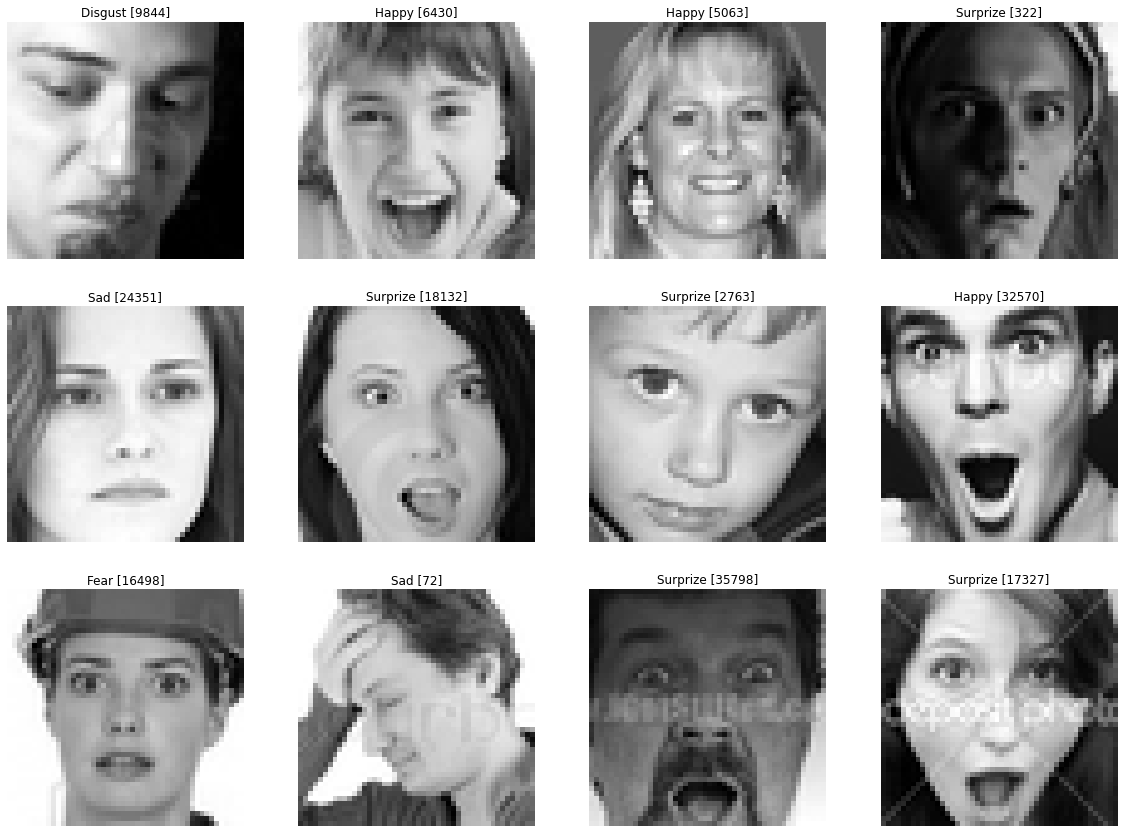

##Here we are also going to use OpenCV for the webcam and model deployement.

#Setting up kaggle api for getting the datset
<hr>

####For that you can go to kaggle.com-> your profile-> Account-> Create New API Token
Then upload the kaggle.json file in google collab and then run the below commands

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle #creating a hidden directory
! cp kaggle.json ~/.kaggle/ #pasting the kaggle api token to above dir
! chmod 600 ~/.kaggle/kaggle.json ## chaging the mode for the file

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


**Put the name of the dataset that you want to use and then unzip the dataset**

In [ ]:
! kaggle datasets download deadskull7/fer2013 # downloading the datset

Dataset URL: https://www.kaggle.com/datasets/deadskull7/fer2013
License(s): CC0-1.0
100% 96.6M/96.6M [00:05<00:00, 20.9MB/s]
100% 96.6M/96.6M [00:05<00:00, 19.0MB/s]


In [ ]:
! unzip /content/fer2013.zip #unzip the downloaded dataset

Archive:  /content/fer2013.zip
  inflating: fer2013.csv             


#Importing necessary files
<hr>



In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D,MaxPool2D,ZeroPadding2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import vgg16
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

#for model deployement
import os
import cv2
import numpy as np
from tensorflow.keras.models import model_from_json
from tensorflow.keras.utils import img_to_array

In [ ]:
df = pd.read_csv('./fer2013.csv') #read dataset

df.head(5),df.shape  #first five rows and count of rows and columns

(   emotion                                             pixels     Usage
 0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
 1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
 2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
 3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
 4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training,
 (35887, 3))

#Exploraotry Data Analysis
<hr>



In [ ]:
print("Null values present in the file:",df.isna().sum().sum())
print("Basic information about the dataframe:")
df.info()

df.describe()

Null values present in the file: 0
Basic information about the dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


,emotion
count,35887.000000
mean,3.323265
std,1.873819
min,0.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,6.000000


In [ ]:
emotions = { #list of available emotions in the dataset
    0:"Angry",
    1:"Disgust",
    2:"Fear",
    3:"Happy",
    4:"Sad",
    5:"Surprize",
    6:"Neutral"
}

##No of images present in dataset corresponding to each emotion

In [ ]:
count_emotions = (df.groupby(df['emotion'])['pixels'].count()).to_frame()
count_emotions['emotion name'] = [emotions[k] for k in emotions.keys()]
count_emotions

,pixels,emotion name
emotion,,
0,4953,Angry
1,547,Disgust
2,5121,Fear
3,8989,Happy
4,6077,Sad
5,4002,Surprize
6,6198,Neutral


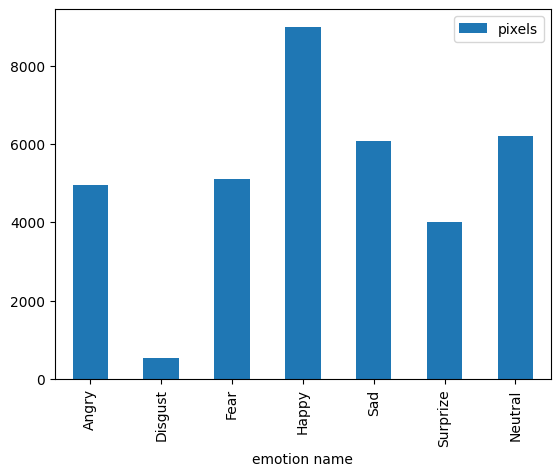

In [ ]:
count_emotions.plot(kind='bar', x='emotion name', y='pixels')
plt.show()

##No of images present in dataset corresponding to training testing and validation part

In [ ]:
count_usage = (df.groupby(df['Usage'])['pixels'].count()).to_frame()
count_usage

,pixels
Usage,
PrivateTest,3589
PublicTest,3589
Training,28709


##Visualizing images from the dataset

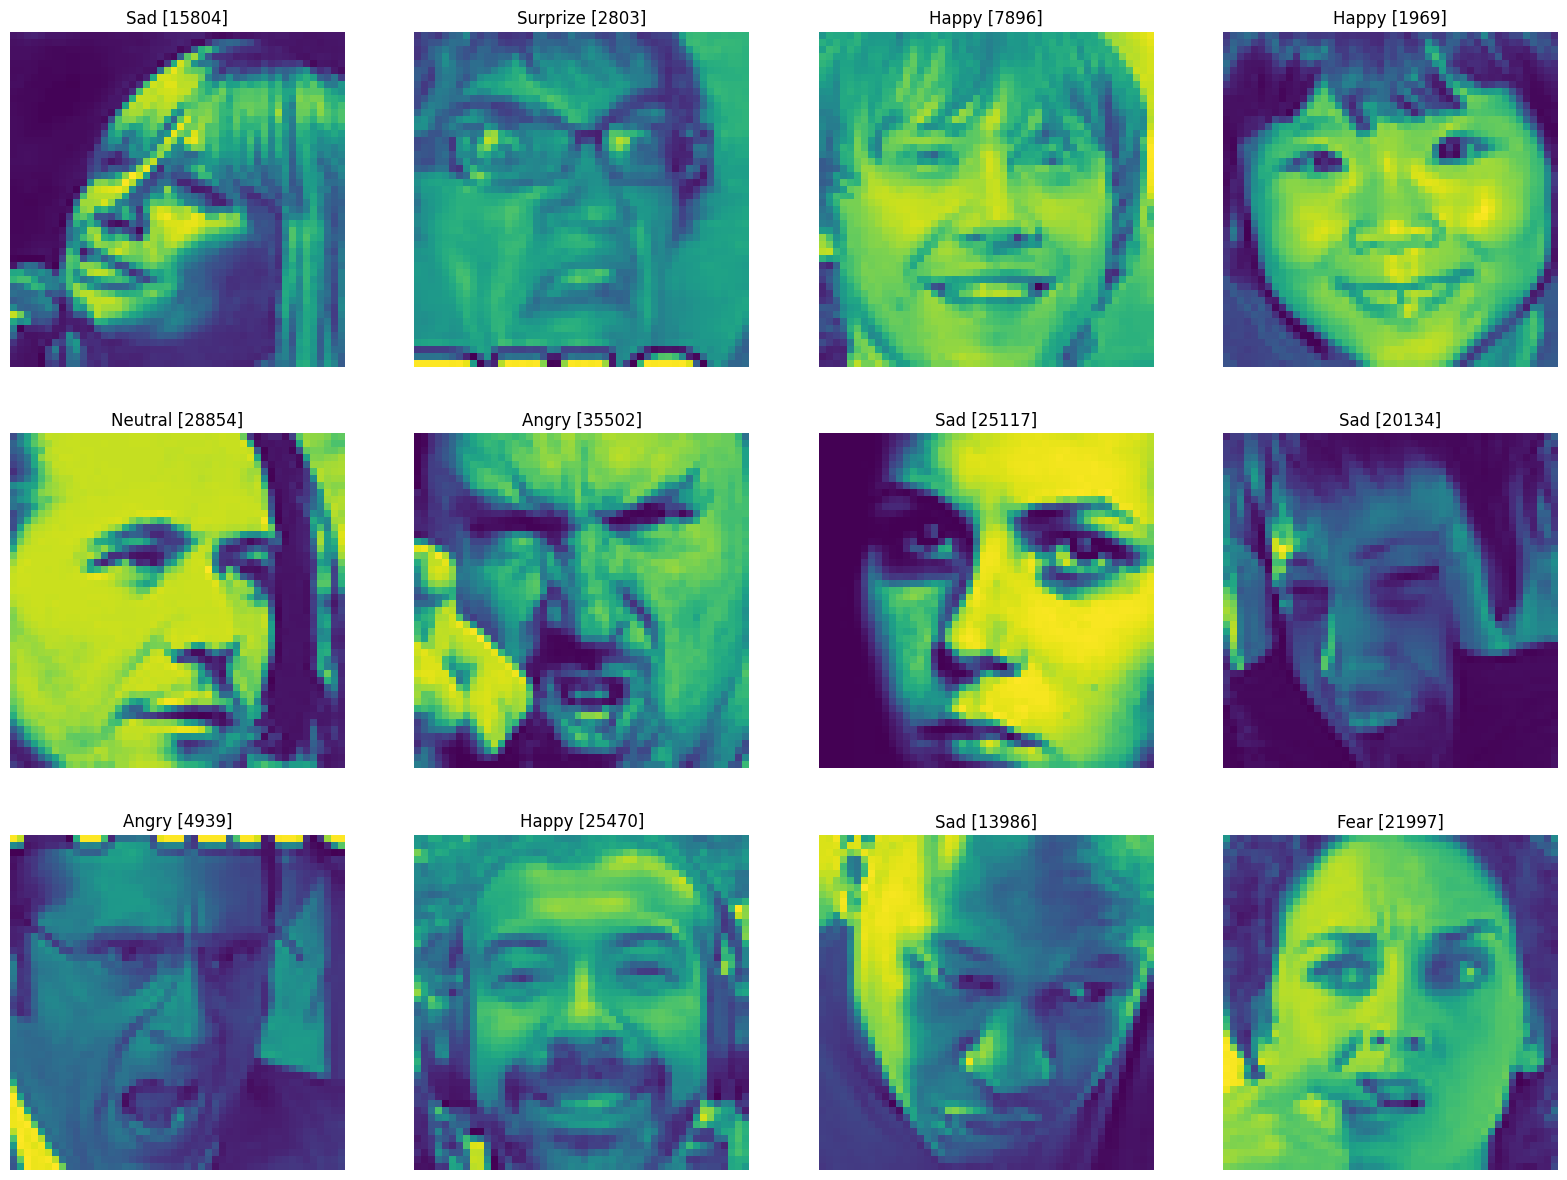

In [ ]:
# from PIL import Image
# pixels = df['pixels'][0]
# b = bytes(int(p) for p in pixels.split())
# i = Image.frombuffer('L',(48,48),b)
# di.save('a.png')
def visualize_images(n_img=4):
    indices = np.random.randint(0,df.shape[0],size=n_img)
#     print(indices)
    plt.figure(figsize=(20,20))
    for i,l in zip(indices,range(0,len(indices))):
        image_ar = np.array([i for i in  df['pixels'][i].split()] , dtype='float')
        pixels = np.reshape(image_ar,(48,48))
        ax = plt.subplot(4,4,l+1)
        plt.imshow(pixels)
        plt.title(emotions[df['emotion'][i]]+" ["+str(i)+"]")
        plt.xticks()
        plt.yticks([])
        plt.axis("off")
visualize_images(12)

#Data Preprocessing
<hr>

## Extracting rows for each part

In [ ]:
X_train,y_train = [],[]
X_val,y_val = [],[]
X_test,y_test = [],[]
for index,row in df.iterrows():
    k = row['pixels'].split(" ")
    if row['Usage'] == 'Training':
        X_train.append(np.array(k))
        y_train.append(row['emotion'])
    elif row['Usage'] == 'PrivateTest':
        X_test.append(np.array(k))
        y_test.append(row['emotion'])
    elif row['Usage'] == 'PublicTest':
        X_val.append(np.array(k))
        y_val.append(row['emotion'])

X_train = np.array(X_train,dtype='float')
y_train = np.array(y_train)
X_test = np.array(X_test,dtype='float')
y_test = np.array(y_test)
X_val = np.array(X_val,dtype='float')
y_val = np.array(y_val)

In [ ]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape,X_val.shape,y_val.shape

((28709, 2304), (28709,), (3589, 2304), (3589,), (3589, 2304), (3589,))

**As you can see above we have to change the shape of the images to train them as the above shape is not compatible**

#Defining Model Archietechture

VGG16

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, ZeroPadding2D

def cnn_model():
    model = Sequential()

    model.add(ZeroPadding2D((1, 1), input_shape=(48, 48, 1), name="block1_pad1"))
    model.add(Conv2D(64, (3, 3), activation='relu', name="block1_l1"))
    model.add(ZeroPadding2D((1, 1), name="block1_pad2"))
    model.add(Conv2D(64, (3, 3), activation='relu', name="block1_l2"))
    model.add(MaxPool2D((2, 2), strides=(2, 2), name="pool1"))

    model.add(ZeroPadding2D((1, 1), name="block2_pad1"))
    model.add(Conv2D(128, (3, 3), activation='relu', name="block2_l1"))
    model.add(ZeroPadding2D((1, 1), name="block2_l2"))
    model.add(Conv2D(128, (3, 3), activation='relu', name="block2_pad2"))
    model.add(MaxPool2D((2, 2), strides=(2, 2), name="pool2"))

    model.add(ZeroPadding2D((1, 1), name="block3_pad1"))
    model.add(Conv2D(256, (3, 3), activation='relu', name="block3_l1"))
    model.add(ZeroPadding2D((1, 1), name="block3_pad2"))
    model.add(Conv2D(256, (3, 3), activation='relu', name="block3_l2"))
    model.add(ZeroPadding2D((1, 1), name="block3_pad3"))
    model.add(Conv2D(256, (3, 3), activation='relu', name="block3_l3"))
    model.add(MaxPool2D((2, 2), strides=(2, 2), name="pool3"))

    model.add(ZeroPadding2D((1, 1), name="block4_pad1"))
    model.add(Conv2D(512, (3, 3), activation='relu', name="block4_l1"))
    model.add(ZeroPadding2D((1, 1), name="block4_pad2"))
    model.add(Conv2D(512, (3, 3), activation='relu', name="block4_l2"))
    model.add(ZeroPadding2D((1, 1), name="block4_pad3"))
    model.add(Conv2D(512, (3, 3), activation='relu', name="block4_l3"))
    model.add(MaxPool2D((2, 2), strides=(2, 2), name="pool4"))

    model.add(ZeroPadding2D((1, 1), name="block5_pad1"))
    model.add(Conv2D(512, (3, 3), activation='relu', name="block5_l1"))
    model.add(ZeroPadding2D((1, 1), name="block5_pad2"))
    model.add(Conv2D(512, (3, 3), activation='relu', name="block5_l2"))
    model.add(ZeroPadding2D((1, 1), name="block5_pad3"))
    model.add(Conv2D(512, (3, 3), activation='relu', name="block5_l3"))
    model.add(MaxPool2D((2, 2), strides=(2, 2), name="pool5"))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu', name="block6"))
    model.add(Dropout(0.5, name="drop1"))
    model.add(Dense(4096, activation='relu', name="block7"))
    model.add(Dropout(0.5, name="drop2"))
    model.add(Dense(7, activation='softmax', name="block8"))

    return model


In [ ]:
# Initialize the model
model = cnn_model()

# Compile the model
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/zero_padding2d.py:72: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ block1_pad1 (ZeroPadding2D)          │ (None, 50, 50, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_l1 (Conv2D)                   │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pad2 (ZeroPadding2D)          │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_l2 (Conv2D)                   │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pad1 (ZeroPadding2D)          │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_l1 (Conv2D)                   │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_l2 (ZeroPadding2D)            │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pad2 (Conv2D)                 │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pad1 (ZeroPadding2D)          │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_l1 (Conv2D)                   │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pad2 (ZeroPadding2D)          │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_l2 (Conv2D)                   │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pad3 (ZeroPadding2D)          │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_l3 (Conv2D)                   │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool3 (MaxPooling2D)                 │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pad1 (ZeroPadding2D)          │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_l1 (Conv2D)                   │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pad2 (ZeroPadding2D)          │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_l2 (Conv2D)                   │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 33,624,775 (128.27 MB)

 Trainable params: 33,624,775 (128.27 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import numpy as np
import pandas as pd
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array
import os

# Path to your CSV dataset
data_path = './fer2013.csv'  # Adjust this to your CSV file location

# Load the dataset from the CSV file
df = pd.read_csv(data_path)

# Emotion dictionary (map emotions from integer labels to human-readable labels)
emotion_dict = {
    0: 'angry',
    1: 'disgust',
    2: 'fear',
    3: 'happy',
    4: 'sad',
    5: 'surprise',
    6: 'neutral'
}

# Create lists to hold images and labels
X = []
y = []

# Iterate over the DataFrame and process each row
for index, row in df.iterrows():
    pixels = row['pixels'].split()  # Split the 'pixels' column into a list of strings
    image_array = np.array(pixels, dtype='float32')  # Convert to numpy array
    image_array = image_array.reshape(48, 48, 1)  # Reshape to 48x48 grayscale image

    X.append(image_array)  # Add image to list
    y.append(row['emotion'])  # Add corresponding label (emotion) to list

# Convert lists to numpy arrays
X = np.array(X, dtype='float32')
y = np.array(y)

# Normalize the images by dividing pixel values by 255 (scaling to [0, 1])
X /= 255.0

# One-hot encode the labels
y = to_categorical(y, num_classes=7)

# Split the data into training, validation, and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shape of the resulting datasets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

# Now you need to reshape the data to include the channel dimension (1 for grayscale images)
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_val = X_val.reshape(X_val.shape[0], 48, 48, 1)

# If you also have a test set (X_test, y_test), you can similarly reshape them
# X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)
# y_test = to_categorical(y_test, num_classes=7)

# Check the reshaped data shapes
print("Reshaped X_train shape:", X_train.shape)
print("Reshaped X_val shape:", X_val.shape)

# Proceed with model training (assuming 'model' is already defined)
checkpointer = [
    EarlyStopping(monitor='val_accuracy', verbose=1, restore_best_weights=True, mode="max", patience=10),
    ModelCheckpoint('best_model.keras', monitor="val_accuracy", verbose=1, save_best_only=True, mode="max")
]

# Train the model
history = model.fit(
    X_train,  # Training data
    y_train,  # Training labels
    batch_size=32,  # Batch size
    epochs=30,  # Number of epochs
    callbacks=checkpointer,  # Callbacks to monitor training
    validation_data=(X_val, y_val)  # Validation data (to monitor performance on unseen data)
)


#Model Evaluation
<hr>

Lets see the output resutls <br>
* Loss plot
* Images with their predicted vs actual label
* Confusion Matrix
* Classification Reprot

In [ ]:
def loss_plot(history):
  plt.plot(history.history["loss"],'r', label="Training Loss")
  plt.plot(history.history["val_loss"],'b', label="Validation Loss")
  plt.legend()

loss_plot(history)

In [ ]:
# Ensure that X_test has the correct shape (num_samples, 48, 48, 1)
# If you don't have a separate test set, you can also split X and y into training and testing sets

# If X_test is not already defined, you can split from the available dataset (e.g., from X and y)
# Assuming X_test and y_test were split beforehand, you can reshape them like this:

# Reshape X_test to have the correct input shape
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

# Normalize X_test as you did for X_train
X_test /= 255.0

# Perform inference using the trained model
preds = model.predict(X_test)

# Convert the predictions to class labels
y_pred = np.argmax(preds, axis=1)

# Now you can evaluate y_pred against the true labels y_test


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to plot images with their labels (actual vs predicted)
def check_images(X_test, y_pred, y_test, label_dict={}):
    figure = plt.figure(figsize=(20, 8))

    for i, index in enumerate(np.random.choice(X_test.shape[0], size=24, replace=False)):
        ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])

        # Display the image (squeezing to remove the single-channel dimension)
        ax.imshow(np.squeeze(X_test[index]), cmap="gray")

        # Get predicted and true labels from y_pred and y_test
        predict_index = label_dict[y_pred[index]]  # predicted label
        true_index = label_dict[np.argmax(y_test[index])]  # true label (after using argmax on one-hot encoded y_test)

        # Set the title to display predicted and true label
        ax.set_title(f"{predict_index} ({true_index})",
                     color="green" if predict_index == true_index else "red")

# Call the function with the data and emotions label dictionary
check_images(X_test, y_pred, y_test, emotions)


In [ ]:
# function to plot confusion matrix
def conf_mat(y_test,y_pred,labels=['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]):
  CLASS_LABELS  = labels
  cm_data = confusion_matrix(np.argmax(y_test, axis = 1 ), y_pred)
  cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
  cm.index.name = 'Actual'
  cm.columns.name = 'Predicted'
  plt.figure(figsize = (20,10))
  plt.title('Confusion Matrix', fontsize = 20)
  sns.set(font_scale=1.2)
  ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [ ]:
conf_mat(y_test,y_pred)

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# If y_test is one-hot encoded, apply np.argmax to get class indices
if y_test.ndim > 1:  # Check if y_test is one-hot encoded
    y_test = np.argmax(y_test, axis=1)

# If y_pred contains probabilities (softmax output), use np.argmax to get class indices
if y_pred.ndim > 1:  # Check if y_pred contains probabilities
    y_pred = np.argmax(y_pred, axis=1)

# Now, print the classification report
print(classification_report(y_test, y_pred, digits=3))


In [ ]:
from tensorflow.keras.utils import to_categorical

# Check if y_test is one-hot encoded (it should be of shape (None, 7) for categorical crossentropy)
# If it's not, convert it using to_categorical()

if y_test.ndim == 1:  # If y_test is 1D, convert to one-hot encoded
    y_test = to_categorical(y_test, num_classes=7)

if y_train.ndim == 1:  # If y_train is 1D, convert to one-hot encoded
    y_train = to_categorical(y_train, num_classes=7)

if y_val.ndim == 1:  # If y_val is 1D, convert to one-hot encoded
    y_val = to_categorical(y_val, num_classes=7)

# Now that y_test, y_train, and y_val are one-hot encoded, we can evaluate the model.
loss_and_metrics = model.evaluate(X_train, y_train)
print("On Training Data", loss_and_metrics)

loss_and_metrics = model.evaluate(X_val, y_val)
print("On Validation Data", loss_and_metrics)

loss_and_metrics = model.evaluate(X_test, y_test)
print("On Test Data", loss_and_metrics)


#Fine Tuning
<hr>

Let's try to improve the model

##1. Changing epoch, learning rate and batch size

In [ ]:
model = cnn_model()
model.compile(optimizer=SGD(learning_rate=0.005),loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=60,
    callbacks=checkpointer,
    validation_data=(X_val,y_val)
)


In [ ]:
loss_plot(history)

In [ ]:
preds = model.predict(X_test)
y_pred = np.argmax(preds , axis = 1 )
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))

##2. Changing optimizer

In [ ]:
# loss and accuracy

model = cnn_model()
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=50,
    callbacks=checkpointer,
    validation_data=(X_val,y_val)
)


In [ ]:
loss_plot(history)

In [ ]:
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))

#Observation

Seems like the model is getting overfitted by the data and the same arch. is not giving better results after tuning.
More steps that can be taken to improve the performance
1. Adding regularization in the model Arch.
2. Adding more data in validation set
3. Try with diff cnn arch

#Model Saving

In [ ]:
# Save model architecture (JSON format)
model_json = model.to_json()  # Convert model architecture to JSON format

# Save the model architecture to a file
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Save the model weights with the correct format
model.save_weights("model.weights.h5")  # Save weights with the .h5 extension (correcting the mistake in the error)

print("Saved model to disk")


#Deploying model using OpenCV
<hr>

Note: Run the below code in your local machine

##loading model arch and weights

In [ ]:
import os
from tensorflow.keras.models import model_from_json  # Import the required function
import cv2

# Load the model architecture from JSON file
model = model_from_json(open("model.json", "r").read())

# Check if the file exists before loading weights
weights_path = 'best_model.h5'

if os.path.exists(weights_path):
    model.load_weights(weights_path)
    print("Model weights loaded successfully.")
else:
    print(f"Error: '{weights_path}' not found. Please check the file path or ensure the file was saved during training.")
    # Handle the error or proceed with default model initialization
    # model = model_from_json(open("model.json", "r").read())  # In case you need to start from scratch

# Initialize Haar Cascade for face detection
face_haar_cascade = cv2.CascadeClassifier('./haarcascade_frontalface_default.xml')

# Additional code for face detection or prediction...


##Open CV code for webcam and prediction

In [ ]:
!pip install opencv-python


In [ ]:
face_haar_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')


In [ ]:
import cv2
import numpy as np
from keras.preprocessing.image import img_to_array
from tensorflow.keras.models import model_from_json

# Load the model architecture from the .json file
with open('/content/model.json', 'r') as json_file:
    model_json = json_file.read()

# Load the model from the JSON architecture
model = model_from_json(model_json)

# Load the weights into the model (ensure the model weights file exists)
model.load_weights('/content/model.weights.h5')  # Replace with the correct path to your weights file

# Load the pre-trained Haar Cascade Classifier for face detection
face_haar_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Start webcam (if running on local machine) or using a video stream in Colab
cap = cv2.VideoCapture(0)  # start webcam for local machine; use a video source URL for Colab

while True:
    # Read a frame from the webcam
    valid, test_image = cap.read()
    if not valid:  # If webcam is not accessible or there's an issue with reading the frame
        break

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces_detected = face_haar_cascade.detectMultiScale(gray_image)

    for (x, y, w, h) in faces_detected:
        # Draw a rectangle around the detected face
        cv2.rectangle(test_image, (x, y), (x + w, y + h), (255, 0, 0), 2)

        # Extract the region of interest (ROI) for the face
        roi_gray = gray_image[y:y + h, x:x + w]
        roi_gray = cv2.resize(roi_gray, (48, 48))  # Resize to 48x48 (model input size)

        # Convert the image to array and expand dimensions for prediction
        image_pixels = img_to_array(roi_gray)
        image_pixels = np.expand_dims(image_pixels, axis=0)  # Add batch dimension

        # Normalize pixel values
        image_pixels /= 255

        # Predict the emotion
        predictions = model.predict(image_pixels)
        max_index = np.argmax(predictions[0])  # Get the index of the highest prediction

        # Map the index to emotion
        emotion_detection = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
        emotion_prediction = emotion_detection[max_index]

        # Put the emotion label on the image
        cv2.putText(test_image, emotion_prediction, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Display the image
    resize_image = cv2.resize(test_image, (1000, 700))  # Resize the image for better visualization
    cv2.imshow('Emotion Detector', resize_image)

    # Exit the loop when 'b' key is pressed
    if cv2.waitKey(10) == ord('b'):
        break

# Release the webcam and close any open windows
cap.release()
cv2.destroyAllWindows()


In [ ]:
import cv2
import numpy as np
from keras.preprocessing.image import img_to_array
from tensorflow.keras.models import model_from_json
from IPython.display import display, Javascript
import matplotlib.pyplot as plt
from PIL import Image as PILImage
import io
import base64
from google.colab import output
import time

# Load the model architecture from the .json file
with open('/content/model.json', 'r') as json_file:
    model_json = json_file.read()
    model = model_from_json(model_json)

# Now, load the weights
model.load_weights('/content/model.weights.h5')  # Ensure the weights file is in the correct path

# Emotion labels
emotion_detection = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

# JavaScript code to use webcam on Google Colab
def start_camera():
    display(Javascript("""
        const video = document.createElement('video');
        video.width = 640;
        video.height = 480;
        document.body.appendChild(video);
        const constraints = {
            video: {
                facingMode: "user"
            }
        };
        navigator.mediaDevices.getUserMedia(constraints).then(function(stream) {
            video.srcObject = stream;
            video.play();
            window.stream = stream;
        });
    """))

# Capture frame from webcam using JavaScript (JS)
def capture_frame():
    display(Javascript("""
        const canvas = document.createElement('canvas');
        const video = document.querySelector('video');
        canvas.width = video.width;
        canvas.height = video.height;
        canvas.getContext('2d').drawImage(video, 0, 0);
        const dataUrl = canvas.toDataURL('image/png');
        google.colab.kernel.invokeFunction('notebook.capture_frame', [dataUrl], {});
    """))

# Store the captured frames and emotions
captured_images = []
captured_emotions = []

# Callback function to handle the captured image
def capture_frame_callback(data_url):
    global captured_images, captured_emotions
    # Decode the base64 image
    img_data = base64.b64decode(data_url.split(',')[1])
    image = PILImage.open(io.BytesIO(img_data))
    img = np.array(image)

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    face_haar_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces_detected = face_haar_cascade.detectMultiScale(gray_image)

    for (x, y, w, h) in faces_detected:
        # Draw a rectangle around the detected face
        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)

        # Extract the region of interest (ROI) for the face
        roi_gray = gray_image[y:y + h, x:x + w]
        roi_gray = cv2.resize(roi_gray, (48, 48))  # Resize to 48x48 (model input size)

        # Convert the image to array and expand dimensions for prediction
        image_pixels = img_to_array(roi_gray)
        image_pixels = np.expand_dims(image_pixels, axis=0)  # Add batch dimension

        # Normalize pixel values
        image_pixels /= 255

        # Predict the emotion
        predictions = model.predict(image_pixels)
        max_index = np.argmax(predictions[0])  # Get the index of the highest prediction

        # Get the emotion prediction
        emotion_prediction = emotion_detection[max_index]

        # Put the emotion label on the image
        cv2.putText(img, emotion_prediction, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Store the captured image and emotion prediction
    captured_images.append(img)
    captured_emotions.append(emotion_prediction)

    # If 5 images have been captured, perform analysis
    if len(captured_images) == 5: #images per mm
        analyze_emotions()

# Function to analyze emotions after capturing 5 photos
def analyze_emotions():
    global captured_images, captured_emotions

    # Display the 5 captured images with their predicted emotions
    plt.figure(figsize=(12, 10))

    for i in range(5):
        plt.subplot(3, 2, i + 1)
        plt.imshow(cv2.cvtColor(captured_images[i], cv2.COLOR_BGR2RGB))
        plt.title(f"Emotion: {captured_emotions[i]}")
        plt.axis('off')

    plt.show()

    # Perform emotional analysis (display the most common emotion)
    emotion_counts = {emotion: captured_emotions.count(emotion) for emotion in captured_emotions}
    most_common_emotion = max(emotion_counts, key=emotion_counts.get)
    print(f"Most common emotion: {most_common_emotion}")

    # Reset for the next cycle
    captured_images.clear()
    captured_emotions.clear()

# Register the callback function
output.register_callback('notebook.capture_frame', capture_frame_callback)

# Start the webcam feed
start_camera()

# Capture photos every 2 seconds and analyze after 5 photos
def capture_and_analyze():
    capture_frame()  # Capture the frame from the webcam

    # Wait for the frame to be captured and analyzed
    time.sleep(2)  # Delay to match the 2-second capture interval

# Continuous loop for capturing images
while True:
    capture_and_analyze()
//if()

In [ ]:
  import cv2
import numpy as np
from keras.preprocessing.image import img_to_array
from tensorflow.keras.models import model_from_json
from IPython.display import display, Javascript
import matplotlib.pyplot as plt
from PIL import Image as PILImage
import io
import base64
from google.colab import output
import time

# Load the model architecture from the .json file
with open('/content/model.json', 'r') as json_file:
    model_json = json_file.read()
    model = model_from_json(model_json)

# Now, load the weights
model.load_weights('/content/model.weights.h5')  # Ensure the weights file is in the correct path

# Emotion labels
emotion_detection = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

# JavaScript code to use webcam on Google Colab
def start_camera():
    display(Javascript("""
        const video = document.createElement('video');
        video.width = 640;
        video.height = 480;
        document.body.appendChild(video);
        const constraints = {
            video: {
                facingMode: "user"
            }
        };
        navigator.mediaDevices.getUserMedia(constraints).then(function(stream) {
            video.srcObject = stream;
            video.play();
            window.stream = stream;
        });
    """))

# Stop the camera feed after 20 seconds
def stop_camera():
    display(Javascript("""
        const video = document.querySelector('video');
        if (video && video.srcObject) {
            const stream = video.srcObject;
            const tracks = stream.getTracks();
            tracks.forEach(track => track.stop()); // Stop all video tracks
            video.srcObject = null;
        }
    """))

# Capture frame from webcam using JavaScript (JS)
def capture_frame():
    display(Javascript("""
        const canvas = document.createElement('canvas');
        const video = document.querySelector('video');
        canvas.width = video.width;
        canvas.height = video.height;
        canvas.getContext('2d').drawImage(video, 0, 0);
        const dataUrl = canvas.toDataURL('image/png');
        google.colab.kernel.invokeFunction('notebook.capture_frame', [dataUrl], {});
    """))

# Store the captured frames and emotions
captured_images = []
captured_emotions = []

# Callback function to handle the captured image
def capture_frame_callback(data_url):
    global captured_images, captured_emotions
    # Decode the base64 image
    img_data = base64.b64decode(data_url.split(',')[1])
    image = PILImage.open(io.BytesIO(img_data))
    img = np.array(image)

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    face_haar_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces_detected = face_haar_cascade.detectMultiScale(gray_image)

    for (x, y, w, h) in faces_detected:
        # Draw a rectangle around the detected face
        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)

        # Extract the region of interest (ROI) for the face
        roi_gray = gray_image[y:y + h, x:x + w]
        roi_gray = cv2.resize(roi_gray, (48, 48))  # Resize to 48x48 (model input size)

        # Convert the image to array and expand dimensions for prediction
        image_pixels = img_to_array(roi_gray)
        image_pixels = np.expand_dims(image_pixels, axis=0)  # Add batch dimension

        # Normalize pixel values
        image_pixels /= 255

        # Predict the emotion
        predictions = model.predict(image_pixels)
        max_index = np.argmax(predictions[0])  # Get the index of the highest prediction

        # Get the emotion prediction
        emotion_prediction = emotion_detection[max_index]

        # Put the emotion label on the image
        cv2.putText(img, emotion_prediction, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Store the captured image and emotion prediction
    captured_images.append(img)
    captured_emotions.append(emotion_prediction)

    # If 5 images have been captured, perform analysis
    if len(captured_images) == 5:
        analyze_emotions()

# Function to analyze emotions after capturing 5 photos
def analyze_emotions():
    global captured_images, captured_emotions

    # Display the 5 captured images with their predicted emotions
    plt.figure(figsize=(12, 10))

    for i in range(5):
        plt.subplot(3, 2, i + 1)
        plt.imshow(cv2.cvtColor(captured_images[i], cv2.COLOR_BGR2RGB))
        plt.title(f"Emotion: {captured_emotions[i]}")
        plt.axis('off')

    plt.show()

    # Perform emotional analysis (display the most common emotion)
    emotion_counts = {emotion: captured_emotions.count(emotion) for emotion in captured_emotions}
    most_common_emotion = max(emotion_counts, key=emotion_counts.get)
    print(f"Most common emotion: {most_common_emotion}")

    # Reset for the next cycle
    captured_images.clear()
    captured_emotions.clear()

# Register the callback function
output.register_callback('notebook.capture_frame', capture_frame_callback)

# Start the webcam feed
start_camera()

# Capture photos every 2 seconds and analyze after 5 photos
def capture_and_analyze():
    capture_frame()  # Capture the frame from the webcam

    # Wait for the frame to be captured and analyzed
    time.sleep(2)  # Delay to match the 2-second capture interval

# Start time for 20-second capture period
start_time = time.time()

# Capture images until 20 seconds have passed
while time.time() - start_time < 20:  # Stop after 20 seconds
    capture_and_analyze()

# Stop the camera feed after 20 seconds
stop_camera()

# The analysis function will be called when 5 images are captured


In [ ]:
  import cv2
import numpy as np
from keras.preprocessing.image import img_to_array
from tensorflow.keras.models import model_from_json
from IPython.display import display, Javascript
import matplotlib.pyplot as plt
from PIL import Image as PILImage
import io
import base64
from google.colab import output
import time

# Load the model architecture from the .json file
with open('/content/model.json', 'r') as json_file:
    model_json = json_file.read()
    model = model_from_json(model_json)

# Now, load the weights
model.load_weights('/content/model.weights.h5')  # Ensure the weights file is in the correct path

# Emotion labels
emotion_detection = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

# JavaScript code to use webcam on Google Colab
def start_camera():
    display(Javascript("""
        const video = document.createElement('video');
        video.width = 640;
        video.height = 480;
        document.body.appendChild(video);
        const constraints = {
            video: {
                facingMode: "user"
            }
        };
        navigator.mediaDevices.getUserMedia(constraints).then(function(stream) {
            video.srcObject = stream;
            video.play();
            window.stream = stream;
        });
    """))

# Stop the camera feed after 20 seconds
def stop_camera():
    display(Javascript("""
        const video = document.querySelector('video');
        if (video && video.srcObject) {
            const stream = video.srcObject;
            const tracks = stream.getTracks();
            tracks.forEach(track => track.stop()); // Stop all video tracks
            video.srcObject = null;
        }
    """))

# Capture frame from webcam using JavaScript (JS)
def capture_frame():
    display(Javascript("""
        const canvas = document.createElement('canvas');
        const video = document.querySelector('video');
        canvas.width = video.width;
        canvas.height = video.height;
        canvas.getContext('2d').drawImage(video, 0, 0);
        const dataUrl = canvas.toDataURL('image/png');
        google.colab.kernel.invokeFunction('notebook.capture_frame', [dataUrl], {});
    """))

# Store the captured frames and emotions
captured_images = []
captured_emotions = []

# Callback function to handle the captured image
def capture_frame_callback(data_url):
    global captured_images, captured_emotions
    # Decode the base64 image
    img_data = base64.b64decode(data_url.split(',')[1])
    image = PILImage.open(io.BytesIO(img_data))
    img = np.array(image)

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    face_haar_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces_detected = face_haar_cascade.detectMultiScale(gray_image)

    for (x, y, w, h) in faces_detected:
        # Draw a rectangle around the detected face
        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)

        # Extract the region of interest (ROI) for the face
        roi_gray = gray_image[y:y + h, x:x + w]
        roi_gray = cv2.resize(roi_gray, (48, 48))  # Resize to 48x48 (model input size)

        # Convert the image to array and expand dimensions for prediction
        image_pixels = img_to_array(roi_gray)
        image_pixels = np.expand_dims(image_pixels, axis=0)  # Add batch dimension

        # Normalize pixel values
        image_pixels /= 255

        # Predict the emotion
        predictions = model.predict(image_pixels)
        max_index = np.argmax(predictions[0])  # Get the index of the highest prediction

        # Get the emotion prediction
        emotion_prediction = emotion_detection[max_index]

        # Put the emotion label on the image
        cv2.putText(img, emotion_prediction, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Store the captured image and emotion prediction
    captured_images.append(img)
    captured_emotions.append(emotion_prediction)

    # If 5 images have been captured, perform analysis
    if len(captured_images) == 5:
        analyze_emotions()

# Function to analyze emotions after capturing 5 photos
def analyze_emotions():
    global captured_images, captured_emotions

    # Display the 5 captured images with their predicted emotions
    plt.figure(figsize=(12, 10))

    for i in range(5):
        plt.subplot(3, 2, i + 1)
        plt.imshow(cv2.cvtColor(captured_images[i], cv2.COLOR_BGR2RGB))
        plt.title(f"Emotion: {captured_emotions[i]}")
        plt.axis('off')

    plt.show()

    # Perform emotional analysis (display the most common emotion)
    emotion_counts = {emotion: captured_emotions.count(emotion) for emotion in captured_emotions}
    most_common_emotion = max(emotion_counts, key=emotion_counts.get)
    print(f"Most common emotion: {most_common_emotion}")

    # Reset for the next cycle
    captured_images.clear()
    captured_emotions.clear()

# Register the callback function
output.register_callback('notebook.capture_frame', capture_frame_callback)

# Start the webcam feed
start_camera()

# Capture photos every 2 seconds and analyze after 5 photos
def capture_and_analyze():
    capture_frame()  # Capture the frame from the webcam

    # Wait for the frame to be captured and analyzed
    time.sleep(2)  # Delay to match the 2-second capture interval

# Start time for 20-second capture period
start_time = time.time()

# Capture images until 20 seconds have passed
while time.time() - start_time < 20:  # Stop after 20 seconds
    capture_and_analyze()

# Stop the camera feed after 20 seconds
stop_camera()

# The analysis function will be called when 5 images are captured
